# Setting up the workspace

## Importing the necessary modules

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
from skimpy import skim
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer #transform different types

## Setting working directory

In [2]:
os.chdir('/Users/lewyiliang/Library/CloudStorage/OneDrive-SIM-SingaporeInstituteofManagement/Year 2/ST2195 - Programming for Data Science/Coursework/dataverse_files')
os.getcwd()  # Prints the current working directory

'/Users/lewyiliang/Library/CloudStorage/OneDrive-SIM-SingaporeInstituteofManagement/Year 2/ST2195 - Programming for Data Science/Coursework/dataverse_files'

## Connecting to coursework_py database

In [3]:
conn = sqlite3.connect('/Users/lewyiliang/Library/CloudStorage/OneDrive-SIM-SingaporeInstituteofManagement/Year 2/ST2195 - Programming for Data Science/Coursework/dataverse_files/coursework_py.db')

## 5. Use the available resources to construct a model that predicts delays.

### Selecting features relevant


In [4]:
q5_features = pd.read_sql_query("""
                                SELECT ontime.Year, Month, DayofMonth, DayOfWeek, DepTime, CRSDepTime, ArrTime, CRSArrTime, AirTime, ArrDelay, DepDelay,
                                 Distance, CarrierDelay, WeatherDelay, NASDelay, SecurityDelay, LateAircraftDelay, 
                                 (ontime.Year - planes.year) AS PlaneAge
                                FROM ontime JOIN planes ON ontime.TailNum = planes.tailnum
                                WHERE Cancelled = 0 AND Diverted = 0 AND PlaneAge >= 0 AND PlaneAge <= 51
                                """, conn)

In [5]:
display(q5_features.head())

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,AirTime,ArrDelay,DepDelay,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,PlaneAge
0,2005,1,28,5,1603.0,1605,1741.0,1759,131.0,-18.0,-2.0,867,0,0,0,0,0,13
1,2005,1,29,6,1559.0,1605,1736.0,1759,136.0,-23.0,-6.0,867,0,0,0,0,0,13
2,2005,1,30,7,1603.0,1610,1741.0,1805,131.0,-24.0,-7.0,867,0,0,0,0,0,17
3,2005,1,31,1,1556.0,1605,1726.0,1759,129.0,-33.0,-9.0,867,0,0,0,0,0,17
4,2005,1,2,7,1934.0,1900,2235.0,2232,106.0,3.0,34.0,867,0,0,0,0,0,15


In [6]:
# To obtain the number of flights
print(len(q5_features)) 

16483019


In [7]:
# Checking for missing values
skim(q5_features)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│           Data Summary                 Data Types                                                               │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                        │
│ ┃ dataframe         ┃ Values   ┃ ┃ Column Type ┃ Count ┃                                                        │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                        │
│ │ Number of rows    │ 16483019 │ │ int64       │ 13    │                                                        │
│ │ Number of columns │ 18       │ │ float64     │ 5     │                                                        │
│ └───────────────────┴──────────┘ └─────────────┴───────┘                                                        │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column_name              ┃ NA   ┃ NA %   ┃ mean    ┃ sd     ┃ p0      ┃ p25    ┃ p75    ┃ p100   ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━┩  │
│ │ Year                     │    0 │      0 │    2000 │   0.82 │    2000 │   2000 │   2000 │   2000 │ ▆  ▇ █  │  │
│ │ Month                    │    0 │      0 │     6.6 │    3.4 │       1 │      4 │     10 │     12 │ ▇█████  │  │
│ │ DayofMonth               │    0 │      0 │      16 │    8.8 │       1 │      8 │     23 │     31 │ ▇▇▇▇▇█  │  │
│ │ DayOfWeek                │    0 │      0 │     3.9 │      2 │       1 │      2 │      6 │      7 │ ▄▄▄▄▄█  │  │
│ │ DepTime                  │    0 │      0 │    1300 │    480 │       0 │    930 │   1700 │   2400 │  ▅███▃  │  │
│ │ CRSDepTime               │    0 │      0 │    1300 │    470 │       1 │    930 │   1700 │   2400 │  ▄██▇▃  │  │
│ │ ArrTime                  │    0 │      0 │    1500 │    510 │       0 │   1100 │   1900 │   2400 │ ▁▂▇██▆  │  │
│ │ CRSArrTime               │    0 │      0 │    1500 │    480 │       0 │   1100 │   1900 │   2400 │  ▂▇██▆  │  │
│ │ AirTime                  │    0 │      0 │     100 │     77 │   -1400 │     55 │    130 │   2000 │     █   │  │
│ │ ArrDelay                 │    0 │      0 │       9 │     37 │    -690 │     -9 │     13 │   2600 │    █    │  │
│ │ DepDelay                 │    0 │      0 │      10 │     34 │   -1200 │     -4 │      9 │   2600 │    █    │  │
│ │ Distance                 │    0 │      0 │     730 │    570 │      11 │    320 │    950 │   5000 │   █▃▁   │  │
│ │ CarrierDelay             │    0 │      0 │     3.6 │     19 │       0 │      0 │      0 │   2600 │    █    │  │
│ │ WeatherDelay             │    0 │      0 │    0.72 │      9 │       0 │      0 │      0 │   1500 │    █    │  │
│ │ NASDelay                 │    0 │      0 │     3.8 │     16 │     -49 │      0 │      0 │   1400 │    █    │  │
│ │ SecurityDelay            │    0 │      0 │   0.026 │    1.2 │       0 │      0 │      0 │    370 │    █    │  │
│ │ LateAircraftDelay        │    0 │      0 │     4.6 │     20 │       0 │      0 │      0 │   1400 │    █    │  │
│ │ PlaneAge                 │    0 │      0 │     9.4 │    7.3 │       0 │      4 │     14 │     51 │   █▃▂   │  │
│ └──────────────────────────┴──────┴────────┴─────────┴────────┴─────────┴────────┴────────┴────────┴─────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

### Randomly sample 200,000 flights from the dataset
#### Due to RAM limitations

In [8]:
sampled_flights = q5_features.sample(n=200000, random_state=123)

In [9]:
print(sampled_flights.head())

          Year  Month  DayofMonth  DayOfWeek  DepTime  CRSDepTime  ArrTime  \
1539181   2005      4          14          4   2005.0        2005   2241.0   
7666040   2006      7          27          4    751.0         755   1612.0   
981720    2005      3           4          5   1200.0        1210   1331.0   
15792369  2007     11          11          7   1444.0        1405   1552.0   
1541761   2005      4          14          4   1656.0        1700   1810.0   

          CRSArrTime  AirTime  ArrDelay  DepDelay  Distance  CarrierDelay  \
1539181         2236    132.0       5.0       0.0       938             0   
7666040         1621    298.0      -9.0      -4.0      2586             0   
981720          1347     78.0     -16.0     -10.0       499             0   
15792369        1535    177.0      17.0      39.0      1371            17   
1541761         1824    234.0     -14.0      -4.0      1825             0   

          WeatherDelay  NASDelay  SecurityDelay  LateAircraftDelay  

### Splitting train and test set

In [10]:
# Features from the dataset
features = ["Year", "Month", "DayofMonth", "DayOfWeek", "DepTime", "CRSDepTime", "ArrTime", "CRSArrTime", "AirTime", "DepDelay", "Distance", "CarrierDelay", "WeatherDelay", "NASDelay", "SecurityDelay", "LateAircraftDelay", "PlaneAge"]
X = sampled_flights[features].copy()
y = sampled_flights["ArrDelay"].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

### Pipelines: Pre-Processing Stage

In [11]:
numerical_features = ["Year", "Month", "DayofMonth", "DayOfWeek", "DepTime", "CRSDepTime", "ArrTime", "CRSArrTime", "AirTime", "DepDelay", "Distance", "CarrierDelay", "WeatherDelay", "NASDelay", "SecurityDelay", "LateAircraftDelay", "PlaneAge"]

# Applying SimpleImputer and StandardScaler into a pipeline
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler())])

data_transformer = ColumnTransformer(
    transformers=[
        ('numerical', numerical_transformer, numerical_features)])

### Setting parameters for hyperparameter tuning

In [12]:
param_grid = {'data_transformer__numerical__imputer__strategy': ['mean', 'median', 'most_frequent']}

### Linear regression model

In [13]:
np.random.seed(123) # Set seed for reproducibility

# Attaching the learner to the data_transformer
pipe_lm = Pipeline(steps=[('data_transformer', data_transformer),
('pipe_lm', LinearRegression())])
grid_lm = GridSearchCV(pipe_lm, param_grid=param_grid, n_jobs = -1)

# Train the linear regression model on the training set
grid_lm.fit(X_train, y_train);

In [14]:
# Make predictions on the test set using the linear regression model
y_predict_lm = grid_lm.predict(X_test)

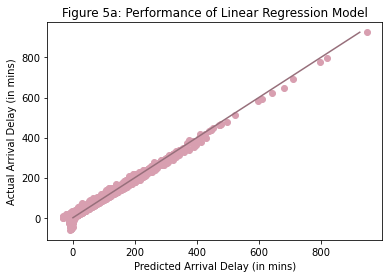

In [15]:
# Create a scatter plot of the actual versus predicted values
plt.scatter(x=y_predict_lm, y=y_test, color='#d89fb0', marker='o')
plt.plot([0, y_test.max()], [0, y_test.max()], color='#976f7b', linestyle='-')
plt.xlabel("Predicted Arrival Delay (in mins)")
plt.ylabel("Actual Arrival Delay (in mins)")
plt.title("Figure 5a: Performance of Linear Regression Model")
plt.show()

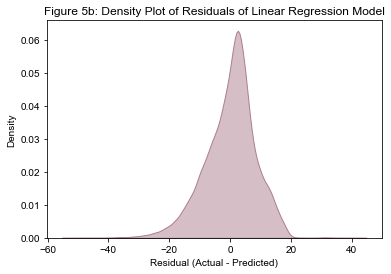

In [16]:
# Create a density plot of the residuals (Actual-Predicted)
sns.kdeplot(x= y_test - y_predict_lm,
            color='#ac7f8c', fill=True, alpha=0.5)
plt.title("Figure 5b: Density Plot of Residuals of Linear Regression Model")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Density")
sns.set_style("white")
sns.set_context("notebook", font_scale=1.2)
sns.set_palette("pastel")
plt.show()

In [17]:
# Predict on the training set
y_predict_train_lm = grid_lm.predict(X_train)

# Calculate evaluation metrics for the training set
train_RMSE = np.sqrt(mean_squared_error(y_train, y_predict_train_lm))
train_MSE = mean_squared_error(y_train, y_predict_train_lm)
train_MAE = mean_absolute_error(y_train, y_predict_train_lm)
train_r2 = r2_score(y_train, y_predict_train_lm)

# Store evaluation metrics in a DataFrame
metrics_lm_train = [train_RMSE, train_MSE, train_MAE, train_r2]
metrics_lm_train = pd.DataFrame(metrics_lm_train)
metrics_lm_train.index = ["RMSE", "MSE", "MAE", "r2"]
metrics_lm_train.columns = ["Linear"]

# Print the evaluation metrics for the training set
metrics_lm_train

,Linear
RMSE,8.412643
MSE,70.772562
MAE,6.441424
r2,0.950300


In [18]:
# Evaluation metrics of the model (Based on test set)
RMSE = np.sqrt(mean_squared_error(y_test, y_predict_lm)) 
MSE = mean_squared_error(y_test, y_predict_lm)
MAE = mean_absolute_error(y_test, y_predict_lm) 
r2 = r2_score(y_test, y_predict_lm) 
metrics_lm = [RMSE, MSE, MAE, r2]
metrics_lm = pd.DataFrame(metrics_lm)
metrics_lm.index = ["RMSE", "MSE", "MAE", "r2"]
metrics_lm.columns = ["Linear"]
metrics_lm

,Linear
RMSE,8.353368
MSE,69.778763
MAE,6.432843
r2,0.947228


### Lasso regression model

In [19]:
# Attaching the learner to the data_transformer
pipe_lasso = Pipeline(steps=[('data_transformer', data_transformer),
('pipe_ridge', Lasso(random_state = 123))])
grid_lasso = GridSearchCV(pipe_lasso, param_grid = param_grid, n_jobs = -1)

# Train the lasso regression model on the training set
grid_lasso.fit(X_train, y_train);

In [20]:
# Make predictions on the test set using the lasso regression model
y_predict_lasso = grid_lasso.predict(X_test)

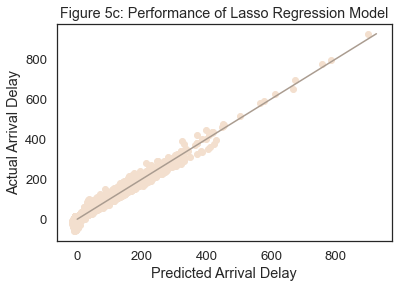

In [21]:
# Create a scatter plot of the actual versus predicted values
plt.scatter(x=y_predict_lasso, y=y_test, color='#f3dfce', marker='o')
plt.plot([0, y_test.max()], [0, y_test.max()], color='#aa9c90', linestyle='-')
plt.xlabel("Predicted Arrival Delay")
plt.ylabel("Actual Arrival Delay")
plt.title("Figure 5c: Performance of Lasso Regression Model")
plt.show()

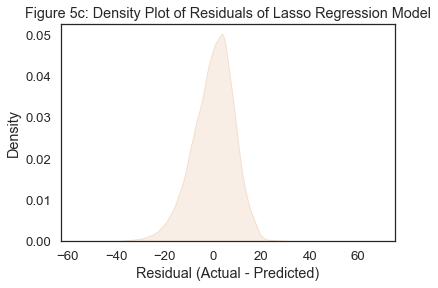

In [22]:
# Create a density plot of the residuals (Actual-Predicted)
sns.kdeplot(x= y_test - y_predict_lasso,
            color='#f3dfce', fill=True, alpha=0.5)
plt.title("Figure 5c: Density Plot of Residuals of Lasso Regression Model")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Density")
sns.set_style("white")
sns.set_context("notebook", font_scale=1.2)
sns.set_palette("pastel")
plt.show()

In [23]:
# Predict on the training set
y_predict_train_lasso = grid_lasso.predict(X_train)

# Calculate evaluation metrics for the training set
train_RMSE = np.sqrt(mean_squared_error(y_train, y_predict_train_lasso))
train_MSE = mean_squared_error(y_train, y_predict_train_lasso)
train_MAE = mean_absolute_error(y_train, y_predict_train_lasso)
train_r2 = r2_score(y_train, y_predict_train_lasso)

# Store evaluation metrics in a DataFrame
metrics_lasso_train = [train_RMSE, train_MSE, train_MAE, train_r2]
metrics_lasso_train = pd.DataFrame(metrics_lasso_train)
metrics_lasso_train.index = ["RMSE", "MSE", "MAE", "r2"]
metrics_lasso_train.columns = ["Lasso"]

# Print the evaluation metrics for the training set
metrics_lasso_train

,Lasso
RMSE,9.032922
MSE,81.593687
MAE,6.911586
r2,0.942701


In [24]:
# Evaluation metrics of the model (Based on test set)
RMSE = np.sqrt(mean_squared_error(y_test, y_predict_lasso))
MSE = mean_squared_error(y_test, y_predict_lasso) 
MAE = mean_absolute_error(y_test, y_predict_lasso)
r2 = r2_score(y_test, y_predict_lasso) 
metrics_lasso = [RMSE, MSE, MAE, r2]
metrics_lasso = pd.DataFrame(metrics_lasso)
metrics_lasso.index = ["RMSE", "MSE", "MAE", "r2"]
metrics_lasso.columns = ["Lasso"]
metrics_lasso

,Lasso
RMSE,8.839547
MSE,78.137588
MAE,6.861608
r2,0.940907


### Ridge regression model

In [25]:
# Attaching the learner to the data_transformer
pipe_ridge = Pipeline(steps=[('data_transformer', data_transformer),
('pipe_ridge', Ridge(solver = 'saga', random_state = 123))])
grid_ridge = GridSearchCV(pipe_ridge, param_grid = param_grid, n_jobs = -1)

# Train the ridge regression model on the training set
grid_ridge.fit(X_train, y_train);

In [26]:
# Make predictions on the test set using the ridge regression model
y_predict_ridge = grid_ridge.predict(X_test)

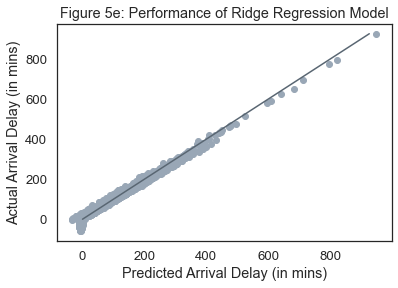

In [27]:
# Create a scatter plot of the actual versus predicted values
plt.scatter(x=y_predict_ridge, y=y_test, color='#99a7b6', marker='o')
plt.plot([0, y_test.max()], [0, y_test.max()], color='#596672', linestyle='-')
plt.xlabel("Predicted Arrival Delay (in mins)")
plt.ylabel("Actual Arrival Delay (in mins)")
plt.title("Figure 5e: Performance of Ridge Regression Model")
plt.show()

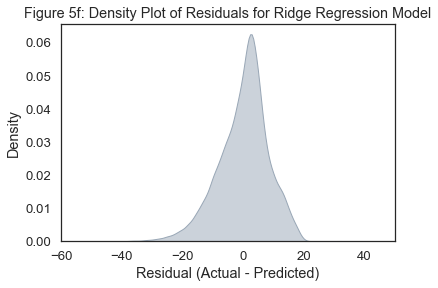

In [28]:
# Create a density plot of the residuals (Actual-Predicted)
sns.kdeplot(x= y_test - y_predict_ridge,
            color='#99a7b6', fill=True, alpha=0.5)
plt.title("Figure 5f: Density Plot of Residuals for Ridge Regression Model")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Density")
sns.set_style("white")
sns.set_context("notebook", font_scale=1.2)
sns.set_palette("pastel")
plt.show()

In [29]:
# Predict on the training set
y_predict_train_ridge = grid_ridge.predict(X_train)

# Calculate evaluation metrics for the training set
train_RMSE = np.sqrt(mean_squared_error(y_train, y_predict_train_ridge))
train_MSE = mean_squared_error(y_train, y_predict_train_ridge)
train_MAE = mean_absolute_error(y_train, y_predict_train_ridge)
train_r2 = r2_score(y_train, y_predict_train_ridge)

# Store evaluation metrics in a DataFrame
metrics_ridge_train = [train_RMSE, train_MSE, train_MAE, train_r2]
metrics_ridge_train = pd.DataFrame(metrics_ridge_train)
metrics_ridge_train.index = ["RMSE", "MSE", "MAE", "r2"]
metrics_ridge_train.columns = ["Ridge"]

# Print the evaluation metrics for the training set
metrics_ridge_train

,Ridge
RMSE,8.412681
MSE,70.773199
MAE,6.441840
r2,0.950300


In [30]:
# Evaluation metrics of the model (Based on test set)
RMSE = np.sqrt(mean_squared_error(y_test, y_predict_ridge))
MSE = mean_squared_error(y_test, y_predict_ridge)
MAE = mean_absolute_error(y_test, y_predict_ridge) 
r2 = r2_score(y_test, y_predict_ridge) 
metrics_ridge = [RMSE, MSE, MAE, r2]
metrics_ridge = pd.DataFrame(metrics_ridge)
metrics_ridge.index = ["RMSE", "MSE", "MAE", "r2"]
metrics_ridge.columns = ["Ridge"]
metrics_ridge

,Ridge
RMSE,8.352793
MSE,69.769150
MAE,6.433107
r2,0.947236


### Random forest

In [31]:
# Attaching the learner to the data_transformer
pipe_rf = Pipeline(steps=[('data_transformer', data_transformer),
    ('rf', RandomForestRegressor(random_state=123))])
# Define the grid search with cross-validation
grid_rf = GridSearchCV(pipe_rf, param_grid=param_grid, n_jobs=-1)

# Train the random forest model on the training set
grid_rf.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('data_transformer',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Year',
                                                                          'Month',
                                                                          'DayofMonth',
                                                                          'DayOfWeek',
                                                                          'DepTime',
         

In [32]:
# Make predictions on the test set using the random forest regression model
y_predict_rf = grid_rf.predict(X_test)

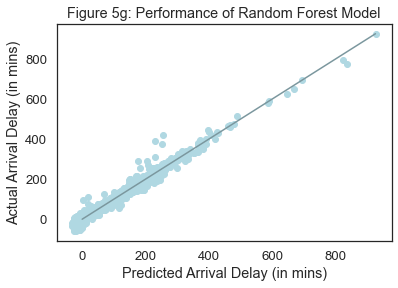

In [33]:
plt.scatter(x=y_predict_rf, y=y_test, color='#b0d8e2', marker='o')
plt.plot([0, y_test.max()], [0, y_test.max()], color='#7b979e', linestyle='-')
plt.xlabel("Predicted Arrival Delay (in mins)")
plt.ylabel("Actual Arrival Delay (in mins)")
plt.title("Figure 5g: Performance of Random Forest Model")
plt.show()

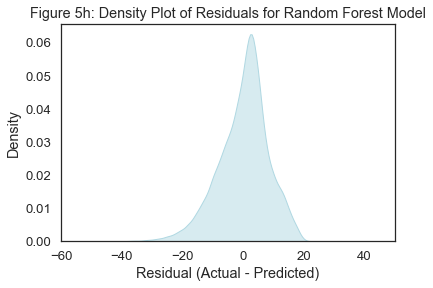

In [34]:
# create a density plot of residuals
sns.kdeplot(x= y_test - y_predict_ridge,
            color='#b0d8e2', fill=True, alpha=0.5)
plt.title("Figure 5h: Density Plot of Residuals for Random Forest Model")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Density")
sns.set_style("white")
sns.set_context("notebook", font_scale=1.2)
sns.set_palette("pastel")
plt.show()

In [35]:
# Predict on the training set
y_predict_train_rf = grid_rf.predict(X_train)

# Calculate evaluation metrics for the training set
train_RMSE = np.sqrt(mean_squared_error(y_train, y_predict_train_rf))
train_MSE = mean_squared_error(y_train, y_predict_train_rf) 
train_MAE = mean_absolute_error(y_train, y_predict_train_rf)
train_r2 = r2_score(y_train, y_predict_train_rf)

# Store evaluation metrics in a DataFrame
metrics_rf_train = [train_RMSE, train_MSE, train_MAE, train_r2]
metrics_rf_train = pd.DataFrame(metrics_rf_train)
metrics_rf_train.index = ["RMSE", "MSE", "MAE", "r2"]
metrics_rf_train.columns = ["Random Forest"]

# Print the evaluation metrics for the training set
metrics_rf_train

,Random Forest
RMSE,2.759580
MSE,7.615284
MAE,1.829372
r2,0.994652


In [36]:
# Evaluation metrics of the model (Based on test set)
RMSE = np.sqrt(mean_squared_error(y_test, y_predict_rf)) 
MSE = mean_squared_error(y_test, y_predict_rf) 
MAE = mean_absolute_error(y_test, y_predict_rf) 
r2 = r2_score(y_test, y_predict_rf) 

metrics_rf = [RMSE, MSE, MAE, r2]
metrics_rf = pd.DataFrame(metrics_rf)
metrics_rf.index = ["RMSE", "MSE", "MAE", "r2"]
metrics_rf.columns = ["Random Forest"]
metrics_rf

,Random Forest
RMSE,7.142198
MSE,51.010998
MAE,4.892276
r2,0.961422


### Comparison

In [37]:
train_metrics_compare = pd.concat([metrics_lm_train, metrics_lasso_train, metrics_ridge_train, metrics_rf_train], axis = 1)
train_metrics_compare

,Linear,Lasso,Ridge,Random Forest
RMSE,8.412643,9.032922,8.412681,2.759580
MSE,70.772562,81.593687,70.773199,7.615284
MAE,6.441424,6.911586,6.441840,1.829372
r2,0.950300,0.942701,0.950300,0.994652


In [38]:
metrics_compare = pd.concat([metrics_lm, metrics_lasso, metrics_ridge, metrics_rf], axis = 1)
metrics_compare

,Linear,Lasso,Ridge,Random Forest
RMSE,8.353368,8.839547,8.352793,7.142198
MSE,69.778763,78.137588,69.769150,51.010998
MAE,6.432843,6.861608,6.433107,4.892276
r2,0.947228,0.940907,0.947236,0.961422


Based on the provided metrics, it appears that the linear and ridge regression models have very similar performance, with very close values for the RMSE, MSE, MAE and R-squared score. However, the Lasso model has slightly higher values for all of these metrics, indicating that it may not be as well-suited for predicting arrival delays as the other two models.

Therefore, between the three models, the linear and ridge regression models seem to be the most well-suited for predicting arrival delays.

## Close the database connection

In [39]:
conn.close()